## Data Preproccessing and amplitude encoding

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Step 1: Loading the Toy Titanic Dataset

In [56]:
df = pd.read_csv('../Data/Raw/toy_titanic.csv')
print("="*80)
print("Toy Dataset:")
print(df)
print("="*80)
print(f"\nDataset shape: {df.shape}")
print("="*80)
print(f"Features: ticket_price, cabin_number")
print(f"Target: survival (1=survived, 0=died, NaN=unknown)")
print("="*80)


Toy Dataset:
    passenger  ticket_price  cabin_number  survival
0  passenger1          8500           910       1.0
1  passenger2          1200          2105       0.0
2  passenger3          7800          1121       NaN

Dataset shape: (3, 4)
Features: ticket_price, cabin_number
Target: survival (1=survived, 0=died, NaN=unknown)


## Step 2: Extract Passenger Data

Extract the 3 passengers from the CSV (P1, P2 with labels; P3 without).

In [57]:
# Passenger 1 (survived)
P1_raw = df.iloc[0][['ticket_price', 'cabin_number']].values  
P1_label = int(df.iloc[0]['survival'])

# Passenger 2 (died)
P2_raw = df.iloc[1][['ticket_price', 'cabin_number']].values  
P2_label = int(df.iloc[1]['survival'])

# Passenger 3 (unknown)
P3_raw = df.iloc[2][['ticket_price', 'cabin_number']].values  

print("Passenger Data:")
print("="*80)
print(f"P1 (Passenger 1): {P1_raw}, label={P1_label} (survived)")
print(f"P2 (Passenger 2): {P2_raw}, label={P2_label} (died)")
print(f"P3 (Passenger 3): {P3_raw}, label=? (to predict)")
print("="*80)

Passenger Data:
P1 (Passenger 1): [np.int64(8500) np.int64(910)], label=1 (survived)
P2 (Passenger 2): [np.int64(1200) np.int64(2105)], label=0 (died)
P3 (Passenger 3): [np.int64(7800) np.int64(1121)], label=? (to predict)


## Step 3: STEP 0 — Min-Max Scaling to [0,1]

Apply the **exact scaling from the book**:
- price_scaled = price / 10000
- cabin_scaled = cabin / 2500

This produces the intermediate values used in the book.

In [58]:
# STEP 0: Min-Max Scaling to [0,1] (Book's exact ranges)
PRICE_MAX = 10000.0
CABIN_MAX = 2500.0

def scale_passenger(p_raw):
    """Scale passenger features to [0,1] using book's ranges."""
    price_scaled = p_raw[0] / PRICE_MAX
    cabin_scaled = p_raw[1] / CABIN_MAX
    return np.array([price_scaled, cabin_scaled])

# Apply scaling to each passenger
P1_scaled = scale_passenger(P1_raw)
P2_scaled = scale_passenger(P2_raw)
P3_scaled = scale_passenger(P3_raw)

print("STEP 0: Min-Max Scaling to [0,1]")
print("="*60)
print(f"P1 (Passenger 1): [{P1_scaled[0]:.2f}, {P1_scaled[1]:.2f}], label={P1_label}")
print(f"P2 (Passenger 2): [{P2_scaled[0]:.2f}, {P2_scaled[1]:.2f}], label={P2_label}")
print(f"P3 (Passenger 3): [{P3_scaled[0]:.2f}, {P3_scaled[1]:.2f}], label=?")

# Verify expected values from book
assert np.isclose(P1_scaled[0], 0.85, atol=0.01), "P1 price should be 0.85"
assert np.isclose(P1_scaled[1], 0.36, atol=0.01), "P1 cabin should be 0.36"
assert np.isclose(P2_scaled[0], 0.12, atol=0.01), "P2 price should be 0.12"
assert np.isclose(P2_scaled[1], 0.84, atol=0.01), "P2 cabin should be 0.84"
assert np.isclose(P3_scaled[0], 0.78, atol=0.01), "P3 price should be 0.78"
assert np.isclose(P3_scaled[1], 0.45, atol=0.01), "P3 cabin should be 0.45"
print("\n✓ Scaled values match book's expected output!")
print("="*60)

STEP 0: Min-Max Scaling to [0,1]
P1 (Passenger 1): [0.85, 0.36], label=1
P2 (Passenger 2): [0.12, 0.84], label=0
P3 (Passenger 3): [0.78, 0.45], label=?

✓ Scaled values match book's expected output!


## Step 5: Construct 4-Qubit Amplitude Vector (STEP B)

Build the **16-element amplitude vector** for 4 qubits with exact structure from the book:

**Normalization:** α = 1/√4 = 0.5

**Structure:**
```
Index   Binary(q0 q1 q2 q3)   Content
  0     0000                   0
  1     0001                   α·P1[0] (P1 with label=1)
  2     0010                   0
  3     0011                   α·P1[1]
  4     0100                   α·P2[0] (P2 with label=0)
  5     0101                   0
  6     0110                   α·P2[1]
  7     0111                   0
  8     1000                   0
  9     1001                   α·P3[0] (P3 copy 1, label=1)
 10     1010                   0
 11     1011                   α·P3[1]
 12     1100                   α·P3[0] (P3 copy 2, label=0)
 13     1101                   0
 14     1110                   α·P3[1]
 15     1111                   0
```

**Key:** Test point P3 is duplicated to enable quantum interference!

In [59]:
# STEP A: L2 Normalization to unit vectors
def normalize_l2(x):
    """Normalize vector to unit length."""
    norm = np.linalg.norm(x)
    return x / norm if norm > 0 else x

# Normalize each passenger
P1 = normalize_l2(P1_scaled)  # label=1 (survived)
P2 = normalize_l2(P2_scaled)  # label=0 (died)
P3 = normalize_l2(P3_scaled)  # label=? (to predict)

print("\nSTEP A: L2 Normalization to Unit Vectors")
print("="*60)
print(f"P1 (Passenger 1): [{P1[0]:.3f}, {P1[1]:.3f}], label={P1_label} (survived)")
print(f"P2 (Passenger 2): [{P2[0]:.3f}, {P2[1]:.3f}], label={P2_label} (died)")
print(f"P3 (Passenger 3): [{P3[0]:.3f}, {P3[1]:.3f}], label=? (to predict)")

# Verify expected values from book
assert np.isclose(P1[0], 0.921, atol=0.005), f"P1[0] should be 0.921, got {P1[0]:.3f}"
assert np.isclose(P1[1], 0.390, atol=0.005), f"P1[1] should be 0.390, got {P1[1]:.3f}"
assert np.isclose(P2[0], 0.141, atol=0.005), f"P2[0] should be 0.141, got {P2[0]:.3f}"
assert np.isclose(P2[1], 0.990, atol=0.005), f"P2[1] should be 0.990, got {P2[1]:.3f}"
assert np.isclose(P3[0], 0.866, atol=0.005), f"P3[0] should be 0.866, got {P3[0]:.3f}"
assert np.isclose(P3[1], 0.500, atol=0.005), f"P3[1] should be 0.500, got {P3[1]:.3f}"

# Verify unit length
assert np.isclose(np.linalg.norm(P1), 1.0), "P1 not unit length"
assert np.isclose(np.linalg.norm(P2), 1.0), "P2 not unit length"
assert np.isclose(np.linalg.norm(P3), 1.0), "P3 not unit length"

print("\n✓ Normalized values match book's expected output!")
print("✓ All vectors have unit length (ready for amplitude encoding)")
print("="*60)


STEP A: L2 Normalization to Unit Vectors
P1 (Passenger 1): [0.919, 0.394], label=1 (survived)
P2 (Passenger 2): [0.141, 0.990], label=0 (died)
P3 (Passenger 3): [0.867, 0.498], label=? (to predict)

✓ Normalized values match book's expected output!
✓ All vectors have unit length (ready for amplitude encoding)


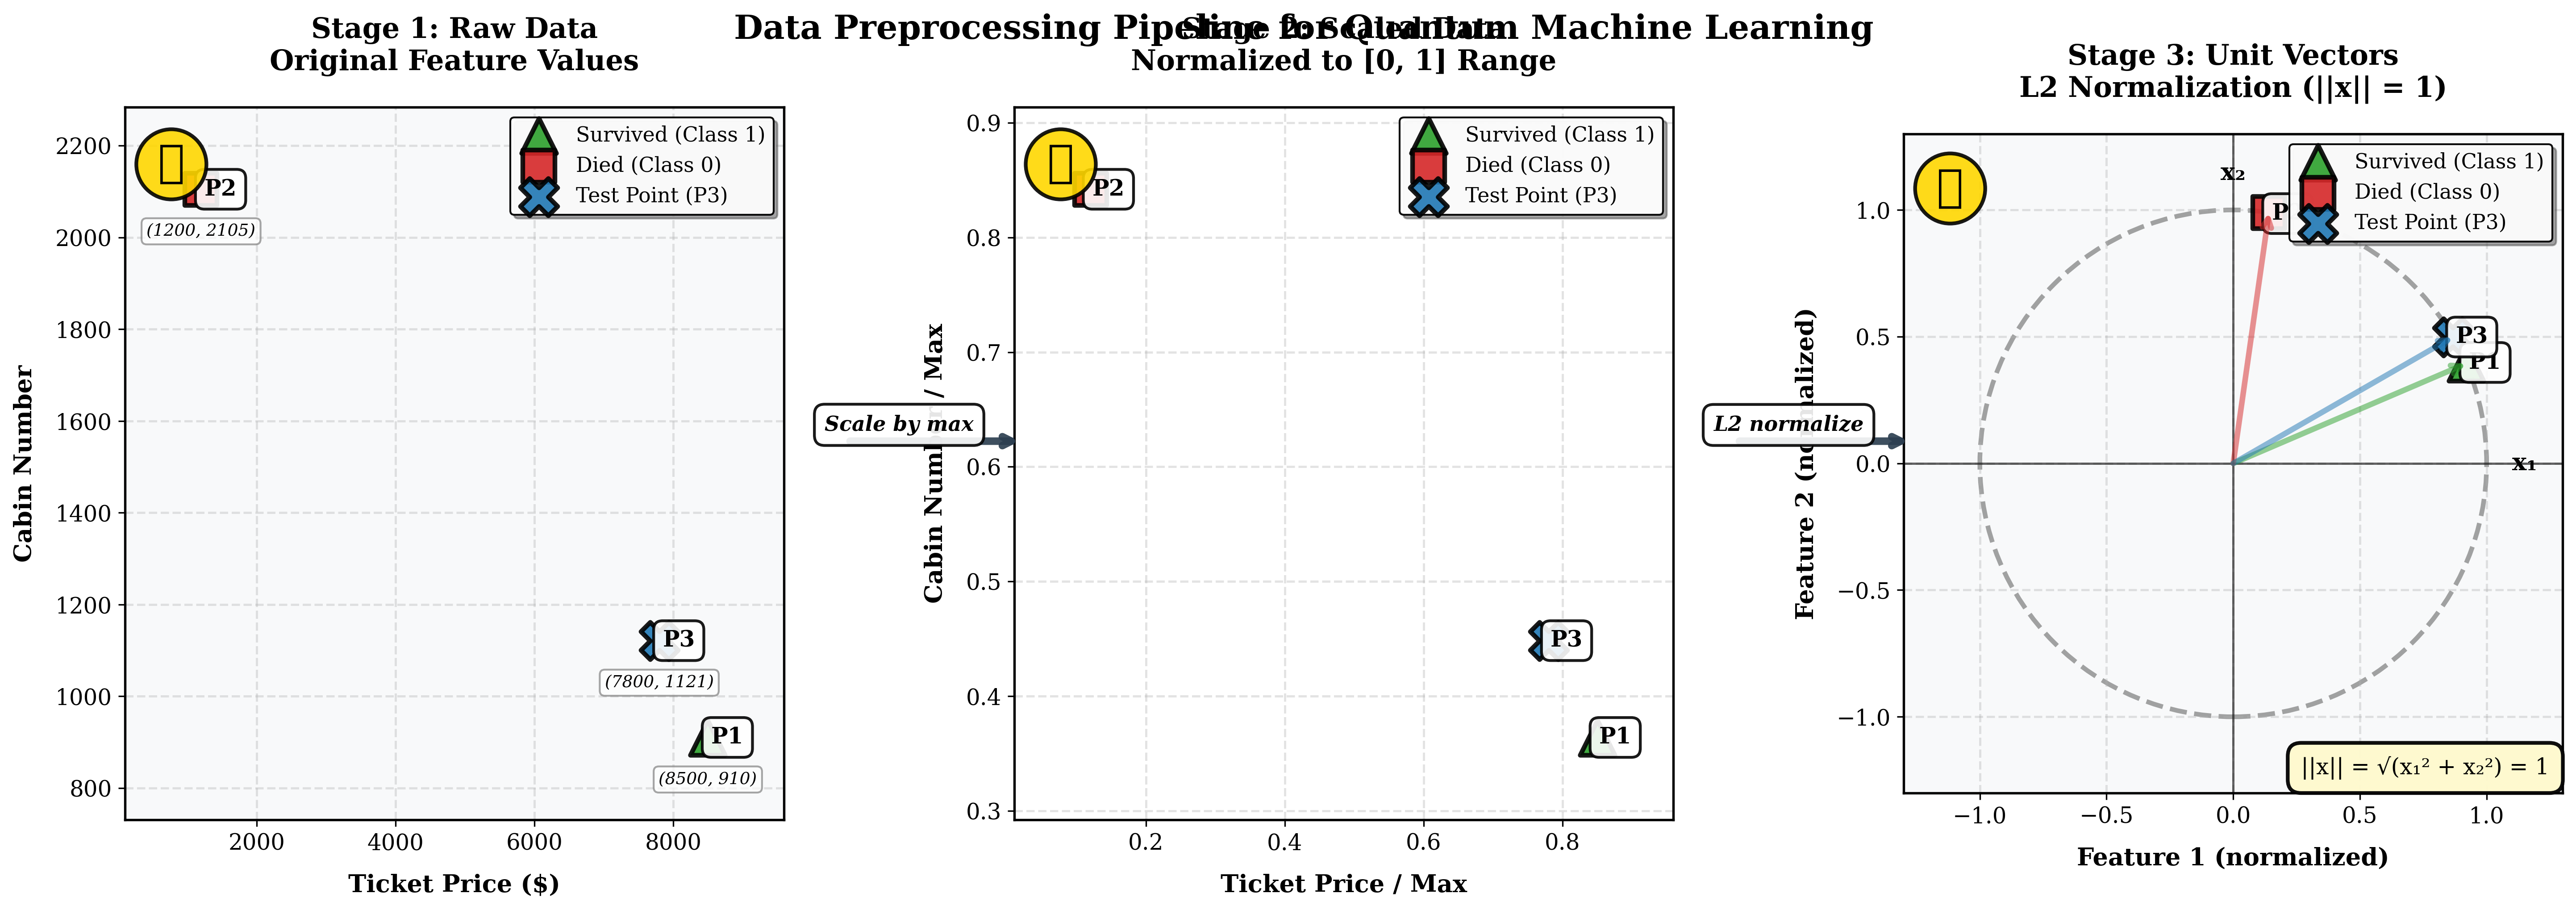

✓ Preprocessing pipeline visualization saved to Figures/

DATA TRANSFORMATION SUMMARY

📊 Stage 1 → Stage 2 (Scaling):
   Formula: x_scaled = x_raw / x_max
   Price max: $10000, Cabin max: 2500

📊 Stage 2 → Stage 3 (Normalization):
   Formula: x_normalized = x_scaled / ||x_scaled||
   Result: All points lie on unit circle (||x|| = 1)

FINAL NORMALIZED DATA (Ready for Quantum Encoding)
  P1 (survived): [0.919257, 0.393658]  →  ||P1|| = 1.000000
  P2 (died):     [0.141092, 0.989996]  →  ||P2|| = 1.000000
  P3 (test):     [0.866954, 0.498388]  →  ||P3|| = 1.000000



In [ ]:
# Create preprocessing pipeline visualization with clean layout
fig = plt.figure(figsize=(22, 8))
gs = fig.add_gridspec(1, 3, hspace=0.05, wspace=0.4, 
                       left=0.05, right=0.98, top=0.90, bottom=0.15)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Define colors and markers - cleaner palette
colors = {0: '#e74c3c', 1: '#27ae60'}  # Cleaner red and green
markers = {0: 'o', 1: 'o'}  # Circles for both
marker_sizes = {0: 250, 1: 250}  # Consistent size
labels_text = {0: 'Died', 1: 'Survived'}

# Prepare data for all three stages
stages_data = [
    {
        'title': 'Raw Data',
        'data': (P1_raw, P2_raw, P3_raw),
        'xlabel': 'Ticket Price ($)',
        'ylabel': 'Cabin Number',
        'stage_num': '1'
    },
    {
        'title': 'Scaled Data',
        'data': (P1_scaled, P2_scaled, P3_scaled),
        'xlabel': 'Normalized Price',
        'ylabel': 'Normalized Cabin',
        'stage_num': '2'
    },
    {
        'title': 'Unit Circle',
        'data': (P1, P2, P3),
        'xlabel': 'x₁',
        'ylabel': 'x₂',
        'stage_num': '3'
    }
]

for idx, stage in enumerate(stages_data):
    ax = axes[idx]
    p1, p2, p3 = stage['data']
    
    # Clean white background
    ax.set_facecolor('white')
    
    # Plot P1 (survived) and P2 (died) - training data
    for point, label, color_key in [(p1, 1, 1), (p2, 0, 0)]:
        ax.scatter(point[0], point[1], 
                  c=colors[color_key], marker=markers[color_key], 
                  s=marker_sizes[color_key], label=labels_text[color_key], 
                  edgecolors='white', linewidths=2, zorder=3, alpha=0.85)
    
    # Plot P3 (unknown) - test data
    ax.scatter(p3[0], p3[1], c='#3498db', marker='s', 
              s=280, label='Test Point', edgecolors='white', 
              linewidths=2, zorder=3, alpha=0.85)
    
    # Add simple point labels
    label_positions = {
        0: [(0, 18), (0, 18), (0, 18)],
        1: [(0, 0.08), (0, 0.08), (0, 0.08)],
        2: [(0.15, 0.08), (-0.2, 0.08), (0.15, -0.08)]
    }
    
    positions = label_positions.get(idx, [(0, 18)] * 3)
    
    for point, label, pos in [(p1, 'P1', positions[0]), 
                               (p2, 'P2', positions[1]), 
                               (p3, 'P3', positions[2])]:
        ax.annotate(label, xy=(point[0], point[1]), 
                   xytext=pos, textcoords='offset points',
                   fontsize=11, fontweight='bold', 
                   bbox=dict(boxstyle='round,pad=0.35', facecolor='white', 
                            edgecolor='gray', linewidth=1, alpha=0.9),
                   ha='center', va='center')
    
    # Stage number badge - simpler design
    ax.text(0.04, 0.96, stage['stage_num'], transform=ax.transAxes,
           fontsize=20, fontweight='bold', va='top', ha='left',
           bbox=dict(boxstyle='round,pad=0.4', facecolor='#ecf0f1', 
                    edgecolor='#7f8c8d', linewidth=1.5, alpha=0.95))
    
    # Styling - cleaner
    ax.set_xlabel(stage['xlabel'], fontsize=12, fontweight='bold', labelpad=8)
    ax.set_ylabel(stage['ylabel'], fontsize=12, fontweight='bold', labelpad=8)
    ax.set_title(stage['title'], fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.8, color='#bdc3c7')
    ax.legend(loc='upper right', fontsize=10, framealpha=0.95, 
             edgecolor='#7f8c8d', fancybox=False, frameon=True)
    
    # Special styling for normalized plot (stage 3)
    if idx == 2:
        # Draw unit circle
        circle = plt.Circle((0, 0), 1, fill=False, color='#95a5a6', 
                           linestyle='--', linewidth=2, alpha=0.7, zorder=1)
        ax.add_patch(circle)
        
        # Draw vectors from origin - lighter
        for point, color_key in [(p1, 1), (p2, 0), (p3, None)]:
            vector_color = colors[color_key] if color_key is not None else '#3498db'
            ax.annotate('', xy=(point[0], point[1]), xytext=(0, 0),
                       arrowprops=dict(arrowstyle='->', lw=2, 
                                      color=vector_color, alpha=0.4,
                                      shrinkA=0, shrinkB=0))
        
        # Set equal aspect and limits
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim([-1.25, 1.25])
        ax.set_ylim([-1.25, 1.25])
        ax.axhline(y=0, color='#7f8c8d', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='#7f8c8d', linewidth=1, alpha=0.5)
        
        # Remove formula - cleaner look
    else:
        # Add some padding to limits for stages 1 and 2
        all_x = [p1[0], p2[0], p3[0]]
        all_y = [p1[1], p2[1], p3[1]]
        x_range = max(all_x) - min(all_x)
        y_range = max(all_y) - min(all_y)
        padding_x = 0.2 * x_range if x_range > 0 else 1
        padding_y = 0.2 * y_range if y_range > 0 else 1
        ax.set_xlim([min(all_x) - padding_x, max(all_x) + padding_x])
        ax.set_ylim([min(all_y) - padding_y, max(all_y) + padding_y])

# Add main title
fig.suptitle('Data Preprocessing Pipeline', 
            fontsize=16, fontweight='bold', y=0.96)

# Add transformation arrows between stages - simpler
arrow_props = dict(arrowstyle='->', lw=3, color='#34495e', alpha=0.6)

for i in range(2):
    ax_from = axes[i]
    ax_to = axes[i+1]
    
    bbox_from = ax_from.get_position()
    bbox_to = ax_to.get_position()
    
    # Arrow position
    x_start = bbox_from.x1 + 0.015
    x_end = bbox_to.x0 - 0.015
    y_pos = (bbox_from.y0 + bbox_from.y1) / 2
    
    arrow = fig.add_artist(plt.annotate('',
                xy=(x_end, y_pos), xycoords='figure fraction',
                xytext=(x_start, y_pos), textcoords='figure fraction',
                arrowprops=arrow_props))
    
    # Add transformation label - smaller
    transform_labels = ['Scale', 'Normalize']
    mid_x = (x_start + x_end) / 2
    fig.text(mid_x, y_pos, transform_labels[i],
            ha='center', va='center', fontsize=10, 
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor='#7f8c8d', linewidth=1, alpha=0.95))

# Save figure with high quality
import os
os.makedirs('../Figures', exist_ok=True)
plt.savefig('../Figures/preprocessing_pipeline.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../Figures/preprocessing_pipeline.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Preprocessing pipeline visualization saved to Figures/")
print(f"\n{'='*80}")
print("DATA TRANSFORMATION SUMMARY")
print(f"{'='*80}")
print(f"\n📊 Stage 1 → Stage 2 (Scaling):")
print(f"   Formula: x_scaled = x_raw / x_max")
print(f"   Price max: ${PRICE_MAX:.0f}, Cabin max: {CABIN_MAX:.0f}")
print(f"\n📊 Stage 2 → Stage 3 (Normalization):")
print(f"   Formula: x_normalized = x_scaled / ||x_scaled||")
print(f"   Result: All points lie on unit circle (||x|| = 1)")
print(f"\n{'='*80}")
print("FINAL NORMALIZED DATA (Ready for Quantum Encoding)")
print(f"{'='*80}")
print(f"  P1 (survived): [{P1[0]:.6f}, {P1[1]:.6f}]  →  ||P1|| = {np.linalg.norm(P1):.6f}")
print(f"  P2 (died):     [{P2[0]:.6f}, {P2[1]:.6f}]  →  ||P2|| = {np.linalg.norm(P2):.6f}")
print(f"  P3 (test):     [{P3[0]:.6f}, {P3[1]:.6f}]  →  ||P3|| = {np.linalg.norm(P3):.6f}")
print(f"{'='*80}\n")


### Visualization: Data Preprocessing Pipeline

Visualize the three preprocessing stages: Raw → Scaled → Normalized

## Step 4: STEP A — L2 Normalization to Unit Vectors

Normalize each scaled vector to unit length for amplitude encoding:
- x_norm = x / ||x||₂

This ensures all vectors have magnitude 1, required for quantum state preparation.

In [61]:
# STEP B: Construct 16-element amplitude vector for 4 qubits
# Normalization factor from book
alpha = 1.0 / np.sqrt(4)

# Build amplitude vector with label encoding
amplitude_vector = np.zeros(16, dtype=complex)

# P1 (label=1, survived): q0=0, q3=1 block
# Indices: 8, 10 (q3=1, q2=0, q1=0/1, q0=0)
amplitude_vector[8] = alpha * P1[0]   # |1000⟩: q0=0, q3=1, feature 0
amplitude_vector[10] = alpha * P1[1]  # |1010⟩: q0=0, q3=1, feature 1

# P2 (label=0, died): q0=0, q3=0 block
# Indices: 0, 2 (q3=0, q2=0, q1=0/1, q0=0)
amplitude_vector[0] = alpha * P2[0]   # |0000⟩: q0=0, q3=0, feature 0
amplitude_vector[2] = alpha * P2[1]   # |0010⟩: q0=0, q3=0, feature 1

# P3 (test, duplicated at q0=1 with both labels for Hadamard interference)
# Copy 1 with label=1: indices 9, 11 (q3=1, q2=0, q1=0/1, q0=1)
amplitude_vector[9] = alpha * P3[0]   # |1001⟩: q0=1, q3=1, feature 0
amplitude_vector[11] = alpha * P3[1]  # |1011⟩: q0=1, q3=1, feature 1

# Copy 2 with label=0: indices 1, 3 (q3=0, q2=0, q1=0/1, q0=1)
amplitude_vector[1] = alpha * P3[0]   # |0001⟩: q0=1, q3=0, feature 0
amplitude_vector[3] = alpha * P3[1]   # |0011⟩: q0=1, q3=0, feature 1

print("\nSTEP B: 4-Qubit Amplitude Encoding")
print("="*60)
print(f"Normalization factor α = 1/√4 = {alpha:.4f}")
print("\nNon-zero amplitudes:")
for i, amp in enumerate(amplitude_vector):
    if np.abs(amp) > 1e-10:
        binary = f"{i:04b}"
        q3_bit = (i >> 3) & 1
        label = "survived" if q3_bit == 1 else "died"
        print(f"  |{binary}⟩: {amp.real:+.4f} (q3={q3_bit}, {label})")

# Verify normalization
norm = np.linalg.norm(amplitude_vector)
print(f"\nAmplitude vector norm: {norm:.6f}")
assert np.isclose(norm, 1.0, atol=1e-6), f"Amplitude vector must be normalized! Got {norm}"
print("✓ Amplitude vector is properly normalized!")
print("✓ P1 (survived) at indices 8,10 with q0=0, q3=1")
print("✓ P2 (died) at indices 0,2 with q0=0, q3=0")
print("✓ P3 at q0=1: indices 1,3 (q3=0) and 9,11 (q3=1) for Hadamard interference!")
print("="*60)


STEP B: 4-Qubit Amplitude Encoding
Normalization factor α = 1/√4 = 0.5000

Non-zero amplitudes:
  |0000⟩: +0.0705 (q3=0, died)
  |0001⟩: +0.4335 (q3=0, died)
  |0010⟩: +0.4950 (q3=0, died)
  |0011⟩: +0.2492 (q3=0, died)
  |1000⟩: +0.4596 (q3=1, survived)
  |1001⟩: +0.4335 (q3=1, survived)
  |1010⟩: +0.1968 (q3=1, survived)
  |1011⟩: +0.2492 (q3=1, survived)

Amplitude vector norm: 1.000000
✓ Amplitude vector is properly normalized!
✓ P1 (survived) at indices 8,10 with q0=0, q3=1
✓ P2 (died) at indices 0,2 with q0=0, q3=0
✓ P3 at q0=1: indices 1,3 (q3=0) and 9,11 (q3=1) for Hadamard interference!


## Step 6: Visualize Normalized Feature Space

Visualize the 3 normalized passengers on the unit circle.

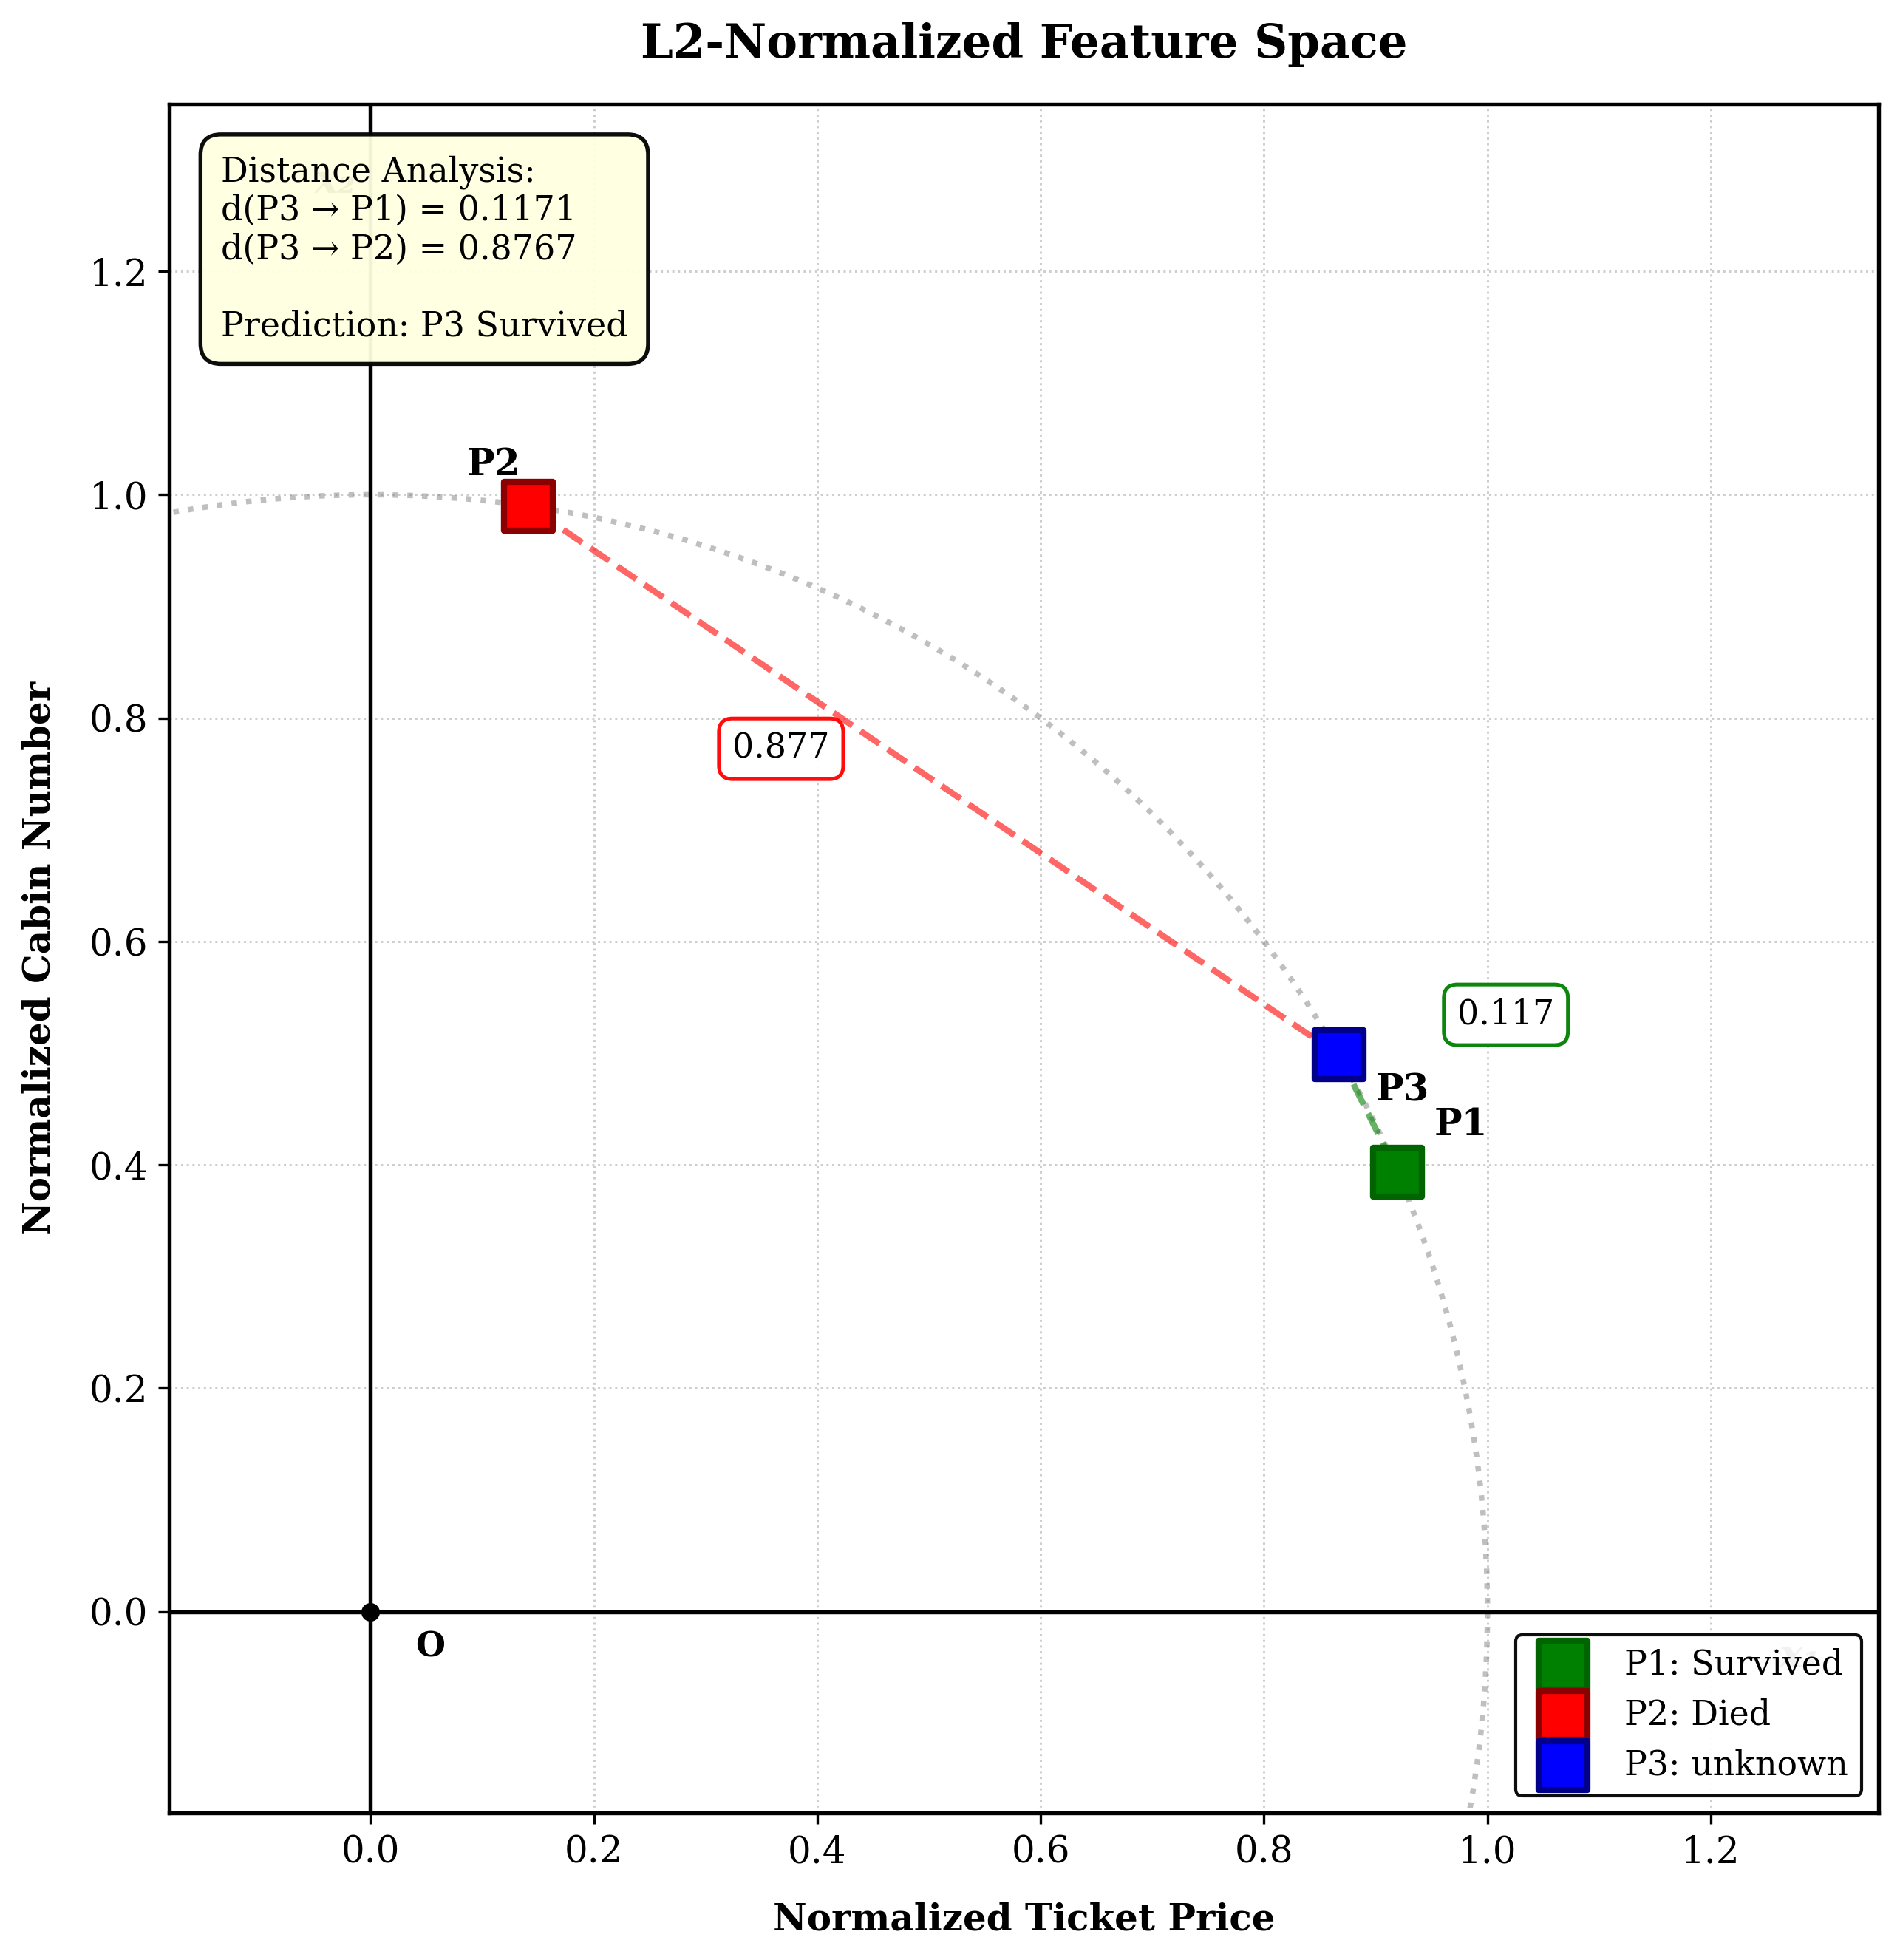

In [62]:
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "axes.linewidth": 1.3,
    "figure.dpi": 300,
    "savefig.dpi": 300,
})

# -----------------------------
# Computing distances between points P3 to P1 and P2
# -----------------------------
dist_P3_P1 = np.linalg.norm(P3 - P1)
dist_P3_P2 = np.linalg.norm(P3 - P2)

# -----------------------------
# Creating figure with larger size for better readability
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 9))

# -----------------------------
# Cartesian axes
# -----------------------------
ax.axhline(0, color='black', linewidth=1.3)
ax.axvline(0, color='black', linewidth=1.3)

ax.text(1.28, -0.05, 'x₁', fontsize=13, ha='center', style='italic', weight='bold')
ax.text(-0.05, 1.28, 'x₂', fontsize=13, va='center', style='italic', weight='bold')

# -----------------------------
# Unit circle
# -----------------------------
circle = plt.Circle((0, 0), 1, fill=False, color='gray',  # type: ignore
                   linestyle=':', linewidth=1.8, alpha=0.5)
ax.add_patch(circle)

# -----------------------------
# Distance vectors
# -----------------------------
ax.plot([P3[0], P1[0]], [P3[1], P1[1]], color='green', 
        linestyle='--', linewidth=2.0, alpha=0.6)
ax.plot([P3[0], P2[0]], [P3[1], P2[1]], color='red', 
        linestyle='--', linewidth=2.0, alpha=0.6)

# -----------------------------
# Scatter points
# -----------------------------
ax.scatter(P1[0], P1[1], s=250, marker='s', color='green', 
          edgecolors='darkgreen', linewidths=2,
          label='P1: Survived', zorder=5)
ax.scatter(P2[0], P2[1], s=250, marker='s', color='red', 
          edgecolors='darkred', linewidths=2,
          label='P2: Died', zorder=5)
ax.scatter(P3[0], P3[1], s=250, marker='s', color='blue', 
          edgecolors='darkblue', linewidths=2,
          label='P3: unknown', zorder=5)

# -----------------------------
# Point labeles
# -----------------------------
ax.annotate('P1', P1, textcoords="offset points", 
           xytext=(12, 12), fontsize=12, fontweight='bold')
ax.annotate('P2', P2, textcoords="offset points", 
           xytext=(-20, 10), fontsize=12, fontweight='bold')
ax.annotate('P3', P3, textcoords="offset points", 
           xytext=(12, -15), fontsize=12, fontweight='bold')

# -----------------------------
# Distance labels 
# -----------------------------
mid_P3_P1 = (P3 + P1) / 2
mid_P3_P2 = (P3 + P2) / 2

ax.text(mid_P3_P1[0]+0.08, mid_P3_P1[1]+0.08, f'{dist_P3_P1:.3f}', 
       fontsize=11, bbox=dict(boxstyle='round,pad=0.4', 
       facecolor='white', edgecolor='green', linewidth=1.2, alpha=0.95))
ax.text(mid_P3_P2[0]-0.18, mid_P3_P2[1]+0.02, f'{dist_P3_P2:.3f}', 
       fontsize=11, bbox=dict(boxstyle='round,pad=0.4', 
       facecolor='white', edgecolor='red', linewidth=1.2, alpha=0.95))

# -----------------------------
# Origin marker
# -----------------------------
ax.plot(0, 0, marker='o', color='black', markersize=5, zorder=5)
ax.text(0.04, -0.04, 'O', fontsize=11, weight='bold')

# -----------------------------
# Labels and title
# -----------------------------
ax.set_xlabel('Normalized Ticket Price', fontsize=12, labelpad=10, weight='bold')
ax.set_ylabel('Normalized Cabin Number', fontsize=12, labelpad=10, weight='bold')
ax.set_title('L2-Normalized Feature Space', fontsize=15, pad=15, weight='bold')

# -----------------------------
# Legend with better styling
# -----------------------------
ax.legend(frameon=True, loc='lower right', fontsize=11, 
         framealpha=0.95, edgecolor='black', fancybox=True)

# -----------------------------
# Grid (lighter, less intrusive)
# -----------------------------
ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.4, color='gray')
ax.set_axisbelow(True)

# -----------------------------
# Axes scaling
# -----------------------------
ax.set_aspect('equal')
ax.set_xlim(-0.18, 1.35)
ax.set_ylim(-0.18, 1.35)

# -----------------------------
# Info box 
# -----------------------------
info_text = (
    f'Distance Analysis:\n'
    f'd(P3 → P1) = {dist_P3_P1:.4f}\n'
    f'd(P3 → P2) = {dist_P3_P2:.4f}\n\n'
    f'Prediction: P3 Survived'
)
ax.text(
    0.03, 0.97,
    info_text,
    transform=ax.transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.6', facecolor='lightyellow', 
             edgecolor='black', linewidth=1.3, alpha=0.95)
)

plt.tight_layout()

import os
os.makedirs('../Figures', exist_ok=True)
plt.savefig(
    '../Figures/toy_feature_space_4qubit.pdf',   
    bbox_inches='tight'
)
plt.savefig(
    '../Figures/toy_feature_space_4qubit.png',
    dpi=300, bbox_inches='tight'
)

plt.show()


## Step 7: Save Preprocessed Data for Next Notebooks

Save all preprocessed data including the 16-element amplitude vector.

In [63]:
# Save processed data for next notebooks
import pickle

processed_data = {
    # Normalized passengers
    'P1': P1,  # [0.921, 0.390], label=1 (survived)
    'P2': P2,  # [0.141, 0.990], label=0 (died)
    'P3': P3,  # [0.866, 0.500], label=? (to be predicted)
    
    # Labels
    'P1_label': P1_label,
    'P2_label': P2_label,
    
    # 4-qubit amplitude vector
    'amplitude_vector': amplitude_vector,
    'alpha': alpha,
    
    # Original dataframe
    'original_data': df
}

import os
os.makedirs('../Data/Processed', exist_ok=True)
output_path = '../Data/Processed/toy_encoded_data_4qubit.pkl'

with open(output_path, 'wb') as f:
    pickle.dump(processed_data, f)

print(f"✓ Processed data saved to {output_path}")
print("\nSummary:")
print("="*60)
print(f"  P1 (survived): {P1}")
print(f"  P2 (died):     {P2}")
print(f"  P3 (unknown):  {P3}")
print(f"  Amplitude vector: 16 elements for 4 qubits")
print(f"  Normalization factor α: {alpha:.4f}")
print("\n✓ Data preprocessing and 4-qubit amplitude encoding complete!")
print("="*60)

✓ Processed data saved to ../Data/Processed/toy_encoded_data_4qubit.pkl

Summary:
  P1 (survived): [0.91925687 0.39365824]
  P2 (died):     [0.14109213 0.98999647]
  P3 (unknown):  [0.86695433 0.49838759]
  Amplitude vector: 16 elements for 4 qubits
  Normalization factor α: 0.5000

✓ Data preprocessing and 4-qubit amplitude encoding complete!
